In [1]:
import numpy as np
import pandas as pd
import tables as tb

import invisible_cities.reco.peak_functions as rp
from invisible_cities.database import load_db

import matplotlib.pyplot as plt

import invisible_cities.reco.calib_sensors_functions as csf
from invisible_cities.types.ic_types import minmax
from invisible_cities.evm.pmaps import S1, S2

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 12, 4
font_size    = 14

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams[  "font.size"   ]  = font_size
plt.rcParams[  "image.cmap"  ]  = default_cmap
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
plt.rcParams["axes.grid"     ]  = True
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

In [3]:
def calibratedwf(wf):
    '''Given a CWF (for all PMT), it returns the total calibrated wf'''
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
#     calwf = calwfs.sum(axis=0)
    return calwf


def s1finder(wf):
    
    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(0, 640)*1000
    length = minmax(4, 100)
    stride = 4
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S1
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    
    #selection of the s1 with maximum height
    h = np.array([s1.height for s1 in res])
    idxs1 = np.argmax(h)
    s1 = res[idxs1]
    
    return s1


def s2finder(wf):

    adc_to_pes = load_db.DataPMT(run).adc_to_pes.values
    calwf = csf.calibrate_wfs(wf, adc_to_pes)
    wf = calwf.sum(axis=0)
    
    rms = 0.5
    index = np.argwhere(wf>rms).flatten()
    
    time = minmax(640, 1300)*1000
    length = minmax(100, 1e4)
    stride = 40
    rebin_stride = 1

    pmt_ids = np.arange(12)
    Pk = S2
    
    ccwfs = calwf
    res = rp.find_peaks(ccwfs, index,
                   time, length,
                   stride, rebin_stride,
                   Pk, pmt_ids,
                   sipm_wfs=None, thr_sipm_s2=0)
    return res

# IMPORT WFS

In [4]:
#wfs
peak = 'Tl_double_escape'
wfdir  = f'./DATA/'
wffilename = f'selected_cwf_{peak}_000.h5'
file = tb.open_file(wfdir+wffilename)
wfs_by_event = file.root.BLR.pmtcwf


#evtsum
run =6482
directory = '../DATA/'
filename  = f'cepks_{run}_0000_11999_6q0min.h5'
data = pd.HDFStore(directory + filename)['/esum']

events = np.array([x['evt_number'] for x in file.root.Run.events.iterrows()])

# SINGLE EVENT WF STUDY

In [5]:
i=int(np.random.random()*len(wfs_by_event))
wfs = wfs_by_event[i]
calwfs = calibratedwf(wfs)

print()
print(f'Event to study: {events[i]}')
print()


Event to study: 1982040



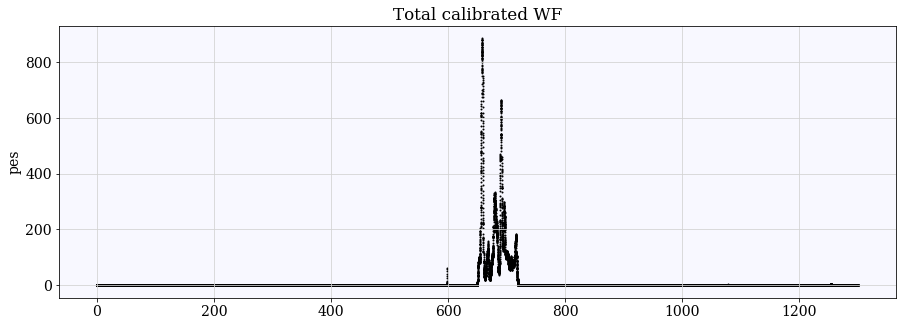

In [6]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(111)
ax.set_title('Total calibrated WF')
ax.scatter(t, calwfs.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');

### Searching S1 and S2

In [7]:
s1 = s1finder(wfs)
s2 = s2finder(wfs)[0]

s1tim = s1.times/1000
s2tim = s2.times/1000

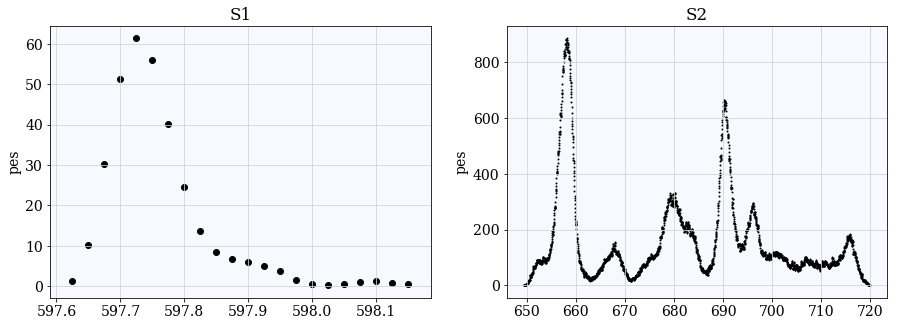

In [8]:
t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])

ax = fig.add_subplot(121)
ax.set_title('S1')
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black')
ax.set_ylabel('pes')

ax = fig.add_subplot(122)
ax.set_title('S2')
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black', s=1)
ax.set_ylabel('pes');

## S2 RAW ENERGY (ADC) BY PMT

In [9]:
t = np.arange(len(wfs.sum(axis=0)))/40
adc_th = 2000
npmt_cut = 1


for i in range(0, 11 + 1): exec(f'PMT_{i}=[]')
evts, sat_evs = [], []
zsize = []

for i in range(0, len(events)):
    
    evt_number = events[i]
    wfs = wfs_by_event[i]
    
    #remove saturated events
    maxs = wfs.max(axis=1)
    npmts_above_adc_th = len(maxs[maxs>adc_th])
    if npmts_above_adc_th>=npmt_cut: 
        sat_evs.append(evt_number)
        continue
        
    #No S2 found    
    try:
        s2 = s2finder(wfs)[0]
    except IndexError: continue
    
    evts.append(evt_number)
    s2tim = s2.times/1000
    idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
    zsize.append(s2tim[-1]-s2tim[0])
    
    for i in range(0, 11 + 1): exec(f'PMT_{i}.append(wfs[i,idx].sum())')

for i in range(0, 11 + 1): exec(f'PMT_{i}=np.array(PMT_{i})')
evts = np.array(evts)
zsize = np.array(zsize)

print('Effective events:', len(evts), '/', len(events))

Effective events: 1617 / 3758


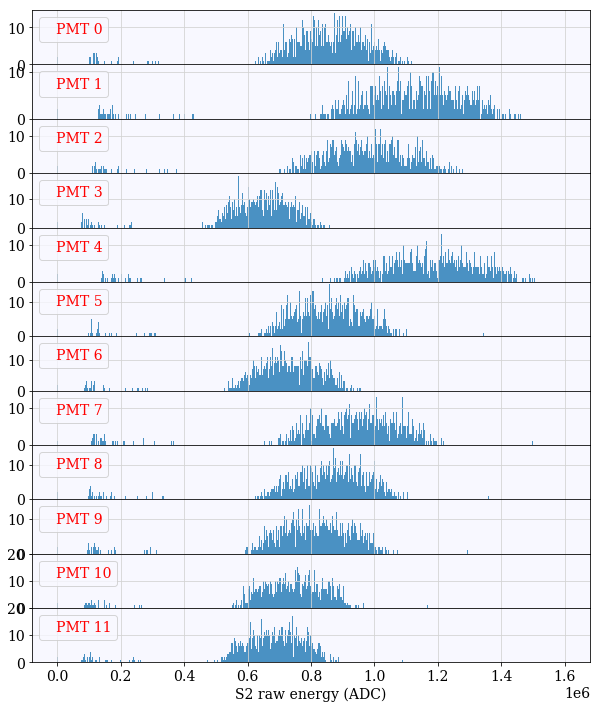

In [10]:
fig = plt.figure(figsize=[10, 12])
rg = (0, 1.6e6)

for i in range(0, 11 + 1):
    exec(f'ax_{i}=fig.add_subplot(12, 1, {i+1})')
    exec(f'ax_{i}.hist(PMT_{i}, bins=1000, range=rg, alpha=0.8)')
    exec(f'ax_{i}.set_xlabel("S2 raw energy (ADC)")')
    exec(f'leg = ax_{i}.legend(["PMT {i}"], loc="upper left", handlelength=0, fancybox=True)')
    exec(f'leg.get_texts()[0].set_color("red")')
    
fig.subplots_adjust(hspace=0)

## EVENTS UNDER ENERGY CUT STUDY

In [13]:
cuts = np.array([0.6, 0.8, 0.6, 0.4, 0.8, 0.6, 0.4, 0.6, 0.6, 0.6, 0.5, 0.4])*1e6

print('Number of events under cut')
print()
for i in range(0, 11 + 1):

    exec(f'idx_{i} = np.argwhere(PMT_{i}<cuts[i]).flatten()')
    exec(f'ev_{i} = evts[idx_{i}]')
    exec(f'print("PMT_{i}:",  len(ev_{i}))')

Number of events under cut

PMT_0: 63
PMT_1: 64
PMT_2: 63
PMT_3: 63
PMT_4: 63
PMT_5: 63
PMT_6: 63
PMT_7: 63
PMT_8: 63
PMT_9: 70
PMT_10: 63
PMT_11: 63


In [14]:
len(np.intersect1d(ev_9, ev_0))

63


Event to study: 13232



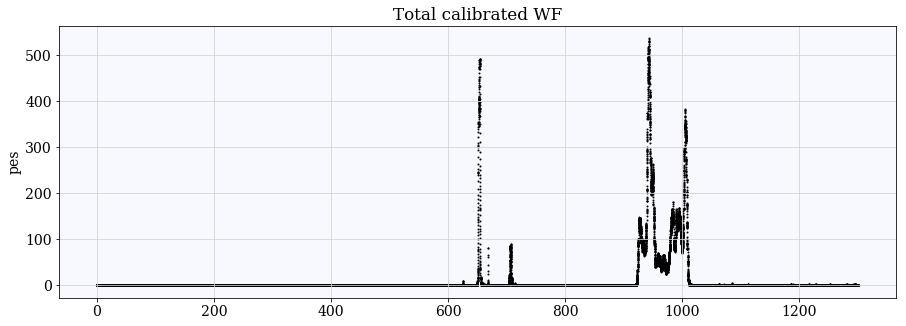

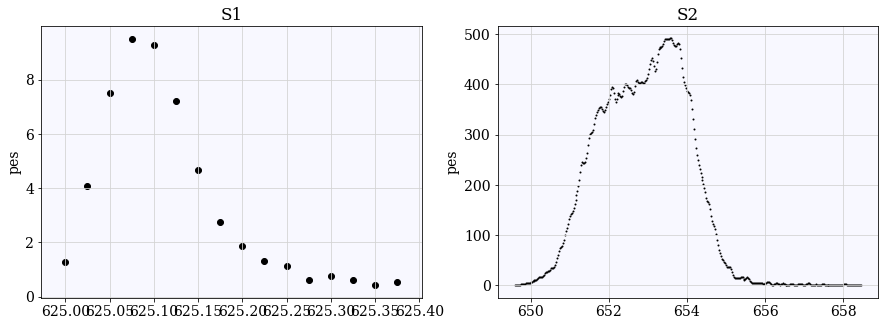

In [15]:
i=5
evt_idx = np.argwhere(events == ev_9[i]).flatten()[0]

wfs = wfs_by_event[evt_idx]
calwfs = calibratedwf(wfs)

print()
print(f'Event to study: {events[i]}')
print()

t = np.arange(len(wfs.sum(axis=0)))/40

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111)
ax.set_title('Total calibrated WF')
ax.scatter(t, calwfs.sum(axis=0), c='black', s=1)
ax.set_ylabel('pes');

s1 = s1finder(wfs)
s2 = s2finder(wfs)[0]

s1tim = s1.times/1000
s2tim = s2.times/1000


fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(121)
ax.set_title('S1')
idx = np.argwhere((s1tim[0]<=t)&(t<=s1tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black')
ax.set_ylabel('pes')

ax = fig.add_subplot(122)
ax.set_title('S2')
idx = np.argwhere((s2tim[0]<=t)&(t<=s2tim[-1])).flatten()
ax.scatter(t[idx], calwfs.sum(axis=0)[idx], c='black', s=1)
ax.set_ylabel('pes');

## MEAN ENERGY vs PMT GAIN

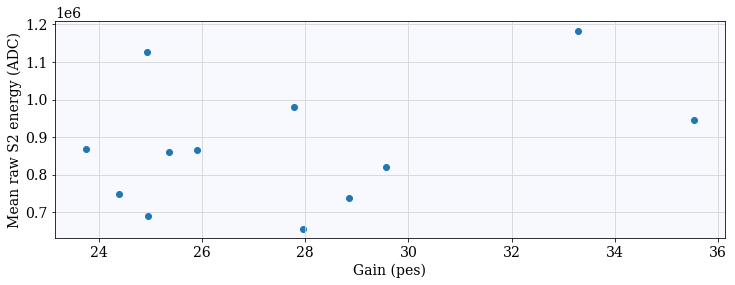

In [16]:
g = np.array([23.7496, 24.9448, 27.7828, 27.9645, 33.2915, 25.361, 28.8426, 35.5306, 25.9013, 29.5728, 24.394, 24.9667])

mean_rawS2 = []
for i in range(0, 11 + 1): exec(f'mean_rawS2.append(PMT_{i}[PMT_{i}>cuts[{i}]].mean())')
mean_rawS2 = np.array([mean_rawS2])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(g, mean_rawS2)
ax.set_ylabel('Mean raw S2 energy (ADC)')
ax.set_xlabel('Gain (pes)');

## S2 RAW ENERGY/ GAIN

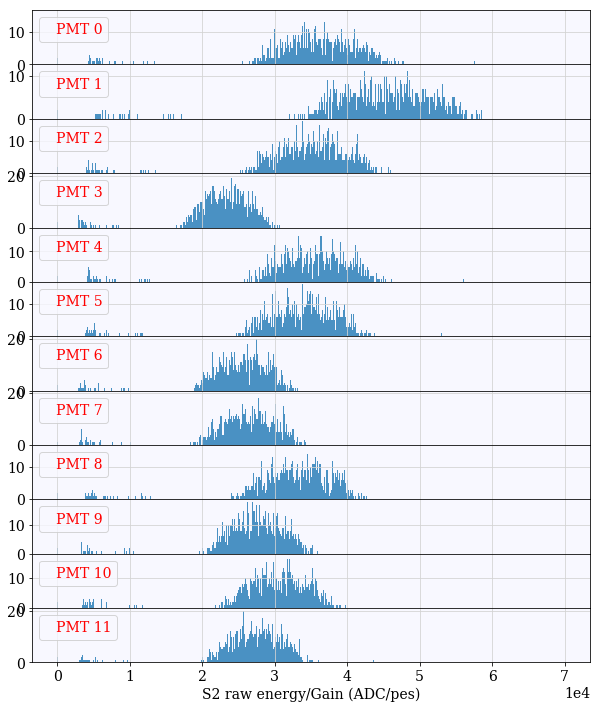

In [17]:
fig = plt.figure(figsize=[10, 12])
rg = (0, 0.7e5)

for i in range(0, 11 + 1):
    exec(f'ax_{i}=fig.add_subplot(12, 1, {i+1})')
    exec(f'ax_{i}.hist(PMT_{i}/g[{i}], bins=1000, range=rg, alpha=0.8)')
    exec(f'ax_{i}.set_xlabel("S2 raw energy/Gain (ADC/pes)")')
    exec(f'leg = ax_{i}.legend(["PMT {i}"], loc="upper left", handlelength=0, fancybox=True)')
    exec(f'leg.get_texts()[0].set_color("red")')
    
fig.subplots_adjust(hspace=0)

## Comparing PMT S2 RAW ENERGIES

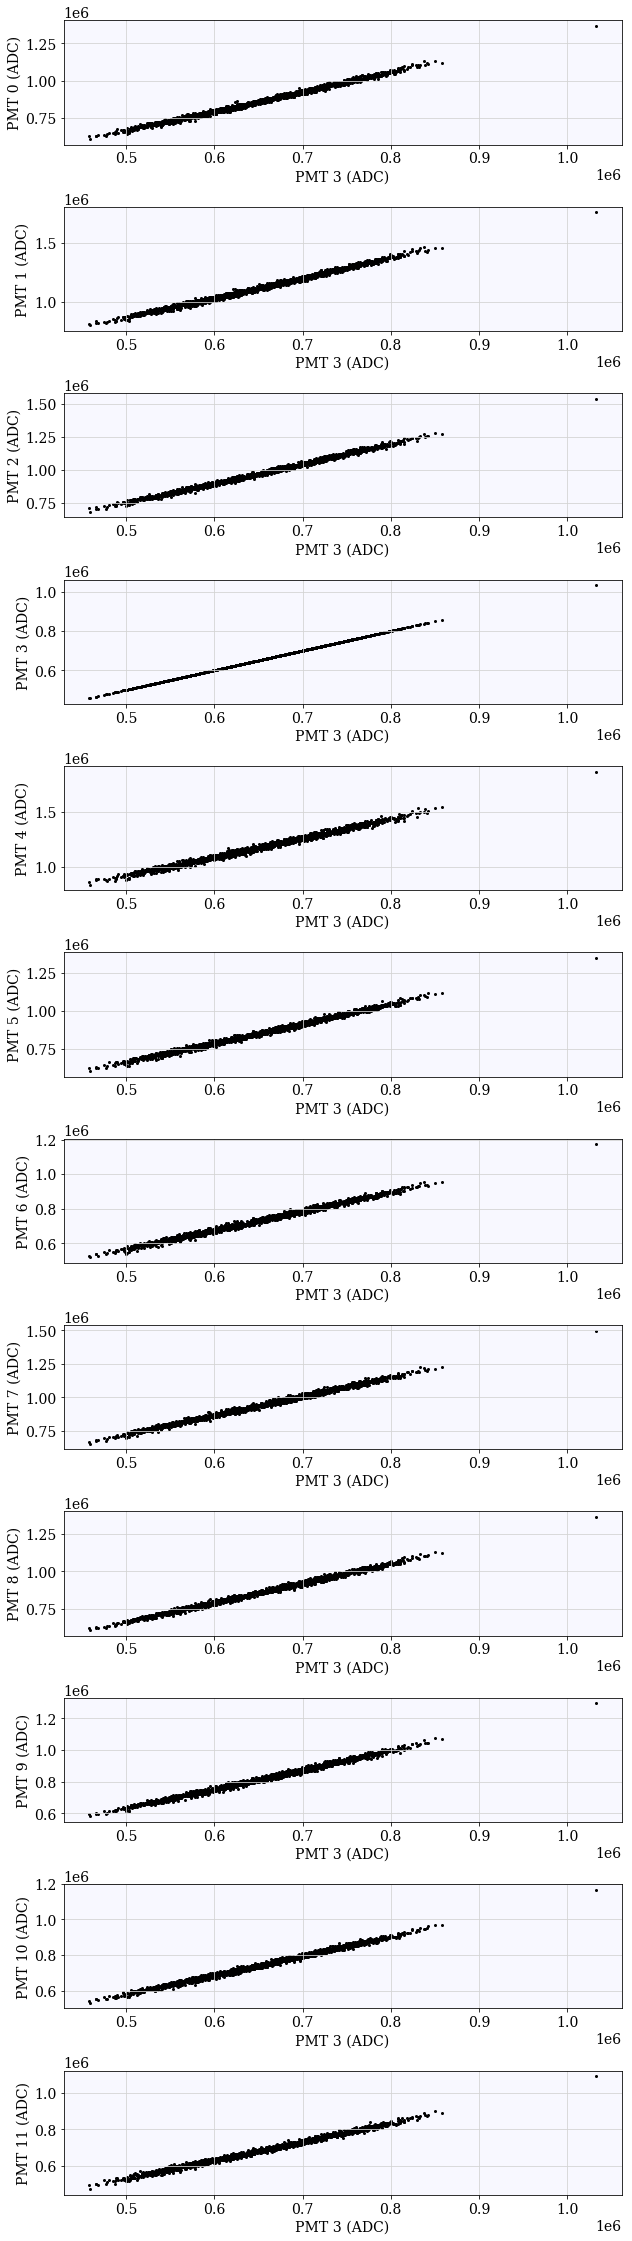

In [21]:
fig = plt.figure(figsize=[10, 40])

idx_3 = np.argwhere(PMT_3>cuts[3]) #to avoid events with not real S2 found

for i in range(0, 11 + 1):
    exec(f'ax_{i}=fig.add_subplot(12, 1, {i+1})')
    exec(f'ax_{i}.scatter(PMT_3[idx_3], PMT_{i}[idx_3], s=4, c="black")')
    
    exec(f'ax_{i}.set_xlabel("PMT 3 (ADC)")')
    exec(f'ax_{i}.set_ylabel("PMT {i} (ADC)")')

fig.subplots_adjust(hspace=0.5)

## S2 RAW ENERGY PMT / S2 RAW ENERGY PMT 3

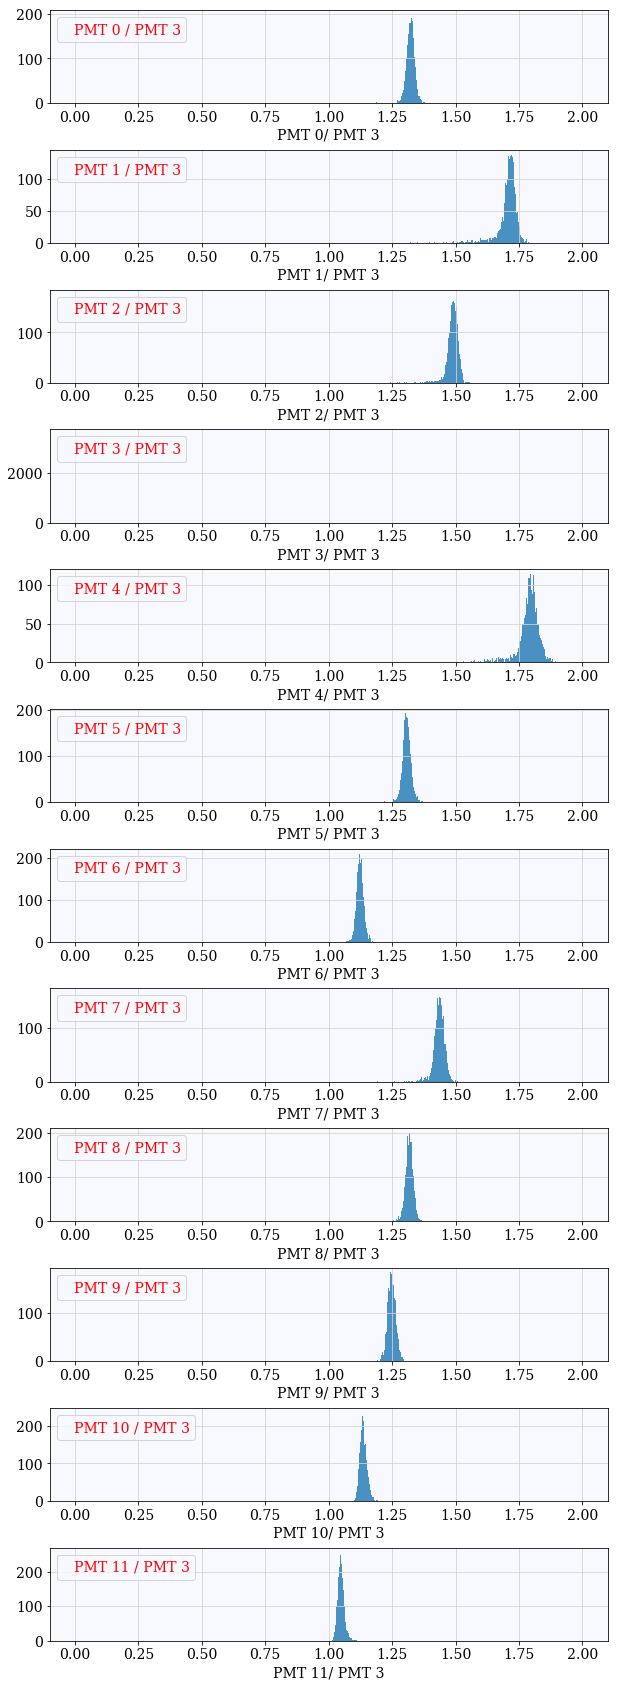

In [18]:
fig = plt.figure(figsize=[10, 30])
rg = (0, 2)

idx_3 = np.argwhere(PMT_3>cuts[3]) #to avoid events with not real S2 found

for i in range(0, 11 + 1):
    exec(f'ax_{i}=fig.add_subplot(12, 1, {i+1})')
    exec(f'ax_{i}.hist(PMT_{i}[idx_3]/PMT_3[idx_3], bins=1000, alpha=0.8, range=rg)')
    exec(f'ax_{i}.set_xlabel("PMT {i}/ PMT 3")')
    exec(f'leg = ax_{i}.legend(["PMT {i} / PMT 3"], loc="upper left", handlelength=0, fancybox=True)')
    exec(f'leg.get_texts()[0].set_color("red")')
    
fig.subplots_adjust(hspace=0.5)

## ZSIZE CORRELATION

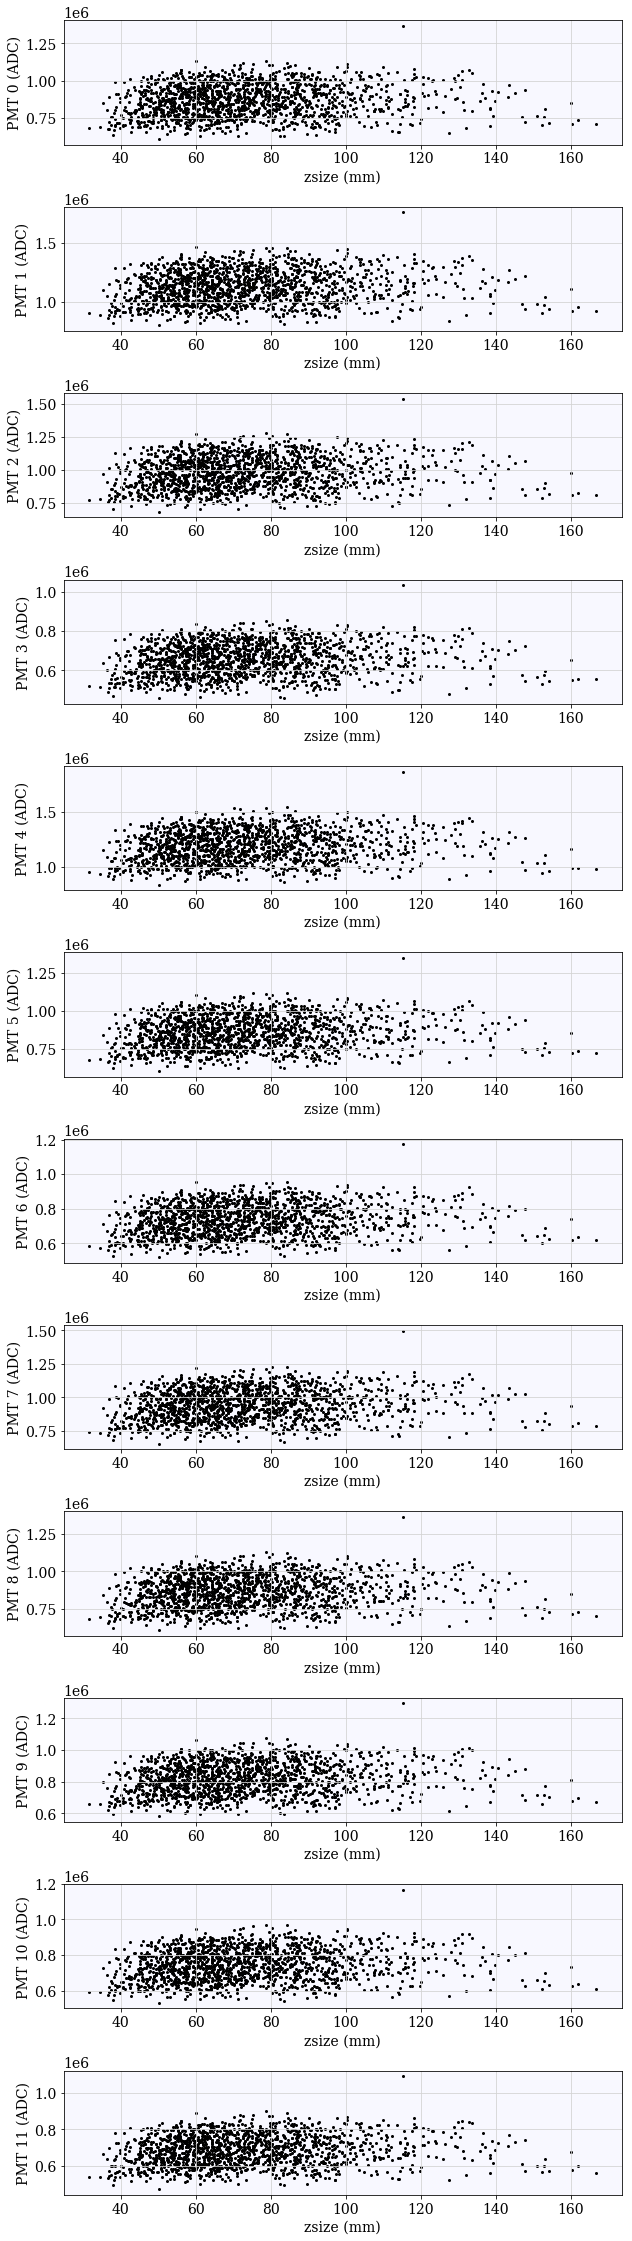

In [18]:
fig = plt.figure(figsize=[10, 40])

idx_3 = np.argwhere(PMT_3>cuts[3]) #to avoid events with not real S2 found
z = zsize[idx_3]

for i in range(0, 11 + 1):
    exec(f'ax_{i}=fig.add_subplot(12, 1, {i+1})')
    exec(f'ax_{i}.scatter(z, PMT_{i}[idx_3], s=4, c="black")')
    
    exec(f'ax_{i}.set_xlabel("zsize (mm)")')
    exec(f'ax_{i}.set_ylabel("PMT {i} (ADC)")')

fig.subplots_adjust(hspace=0.5)